In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score

import shap

import warnings
warnings.simplefilter("ignore")

Подгружаем данные

In [2]:
marketing_df = pd.read_csv("marketing_campaign.csv", delimiter="\t")

In [3]:
marketing_df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [4]:
marketing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [5]:
marketing_df = marketing_df[marketing_df["Income"] < 100000]
marketing_df = marketing_df[marketing_df["Year_Birth"] > 1920]

Зависимость дохода от семейного положения

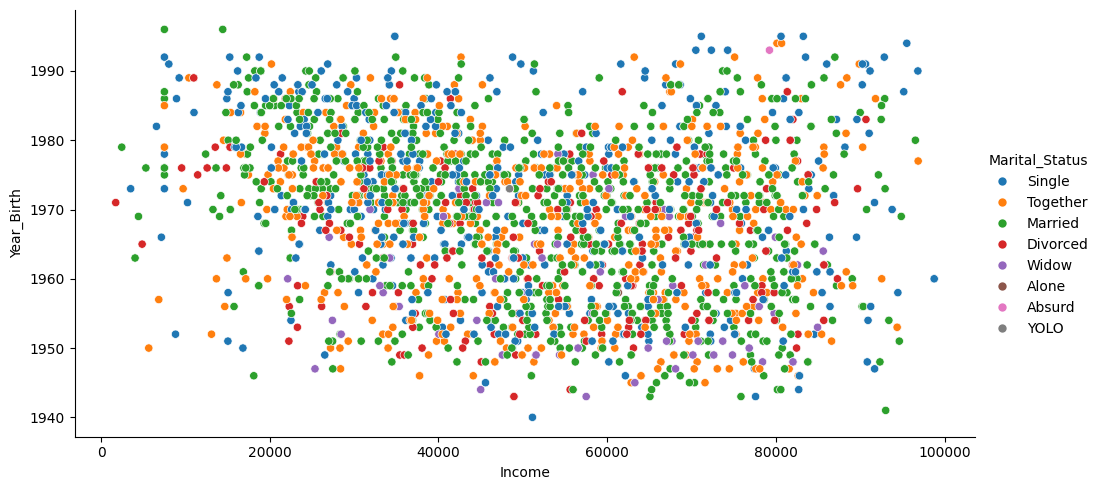

In [6]:
g = sns.relplot(
    data=marketing_df,
    x="Income",
    y="Year_Birth",
    hue="Marital_Status",
    kind="scatter",
    aspect=2,
)

Закономерностей не наблюдается

Как зависит семейное положение от кол-ва детей в семье клиента?

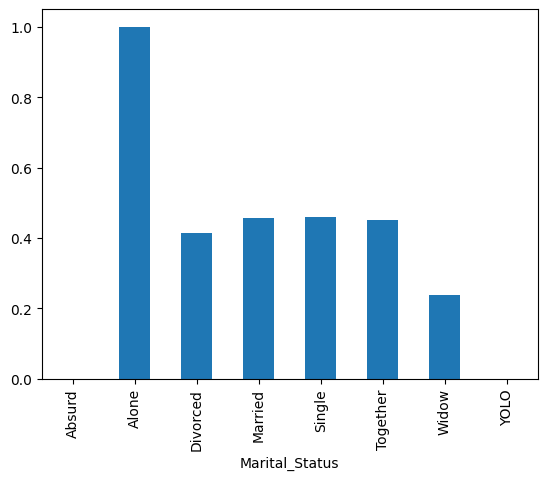

In [7]:
tmp_df = marketing_df.groupby("Marital_Status").agg(kidhome_sum=("Kidhome", "sum"),
                                           group_amount=("Kidhome", "count"))
tmp_df["kidhome_sum_norm"] = tmp_df["kidhome_sum"] / tmp_df["group_amount"]
tmp_df["kidhome_sum_norm"].plot(kind="bar");

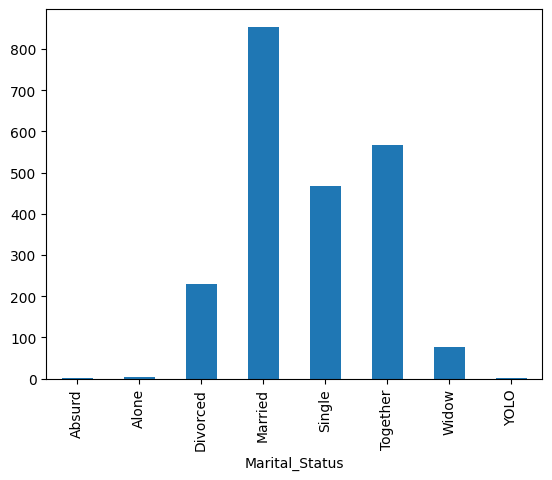

In [8]:
tmp_df["group_amount"].plot(kind="bar");

Среднее кол-во детей в каждоый группе особо не меняется

Как зависят траты на золото в зависимости от дохода?

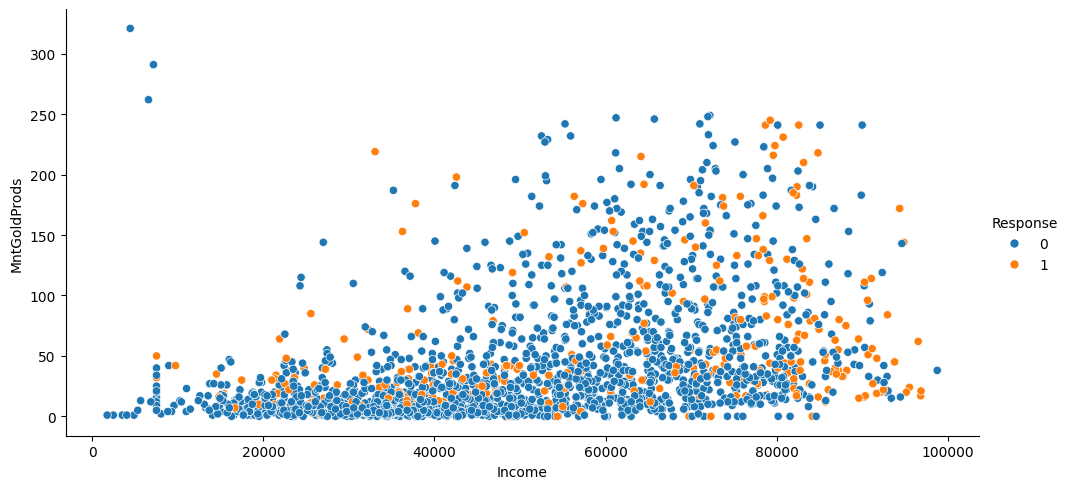

In [9]:
g = sns.relplot(
    data=marketing_df,
    x="Income",
    y="MntGoldProds",
    hue="Response",
    kind="scatter",
    aspect=2,
)

Чем больше зарабатывает, тем больше вкладывает в золото (что логично). На принятие компании это не влияет.

Как зависит кол-во покупок через веб-сайт/непосредственно в магазине от возраста
человека?

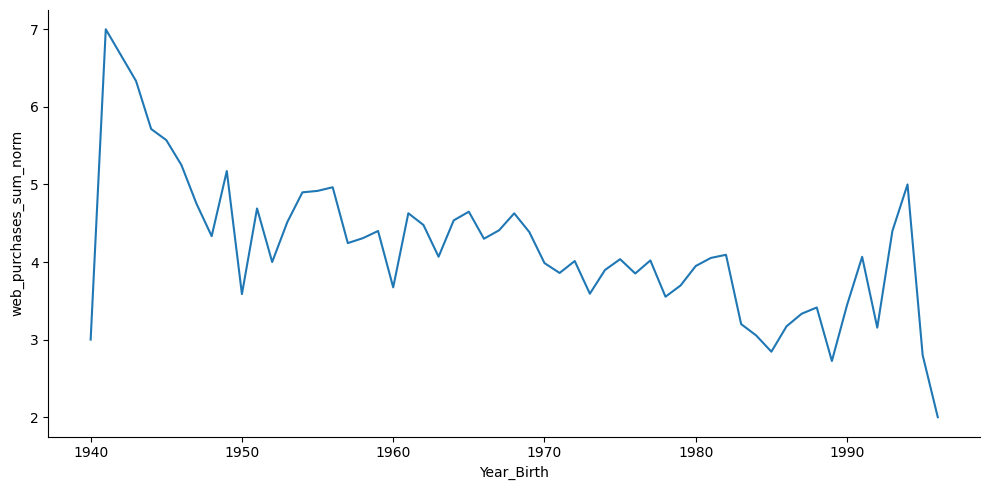

In [10]:
tmp_df = marketing_df.groupby("Year_Birth", as_index=False).agg(
    web_purchases_sum=("NumWebPurchases", "sum"),
    store_purchases_sum=("NumStorePurchases", "sum"),
    group_count=("NumStorePurchases", 'count')
)
tmp_df['web_purchases_sum_norm'] = tmp_df['web_purchases_sum'] / tmp_df['group_count']
tmp_df['store_purchases_sum_norm'] = tmp_df['store_purchases_sum'] / tmp_df['group_count']

g = sns.relplot(
    data=tmp_df,
    x="Year_Birth",
    y="web_purchases_sum_norm",
    kind="line",
    aspect=2,
)

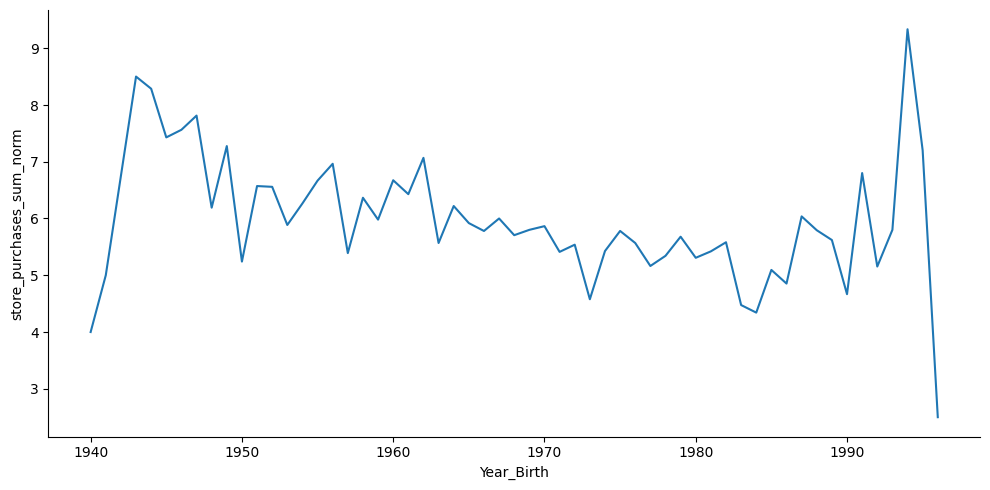

In [11]:
g = sns.relplot(
    data=tmp_df,
    x="Year_Birth",
    y="store_purchases_sum_norm",
    kind="line",
    aspect=2,
)

Нужно разделить полученную сумму на долю человек этого возраста. Зависимостей никаких не прослеживается. 

Как образование влияет на уровень дохода?

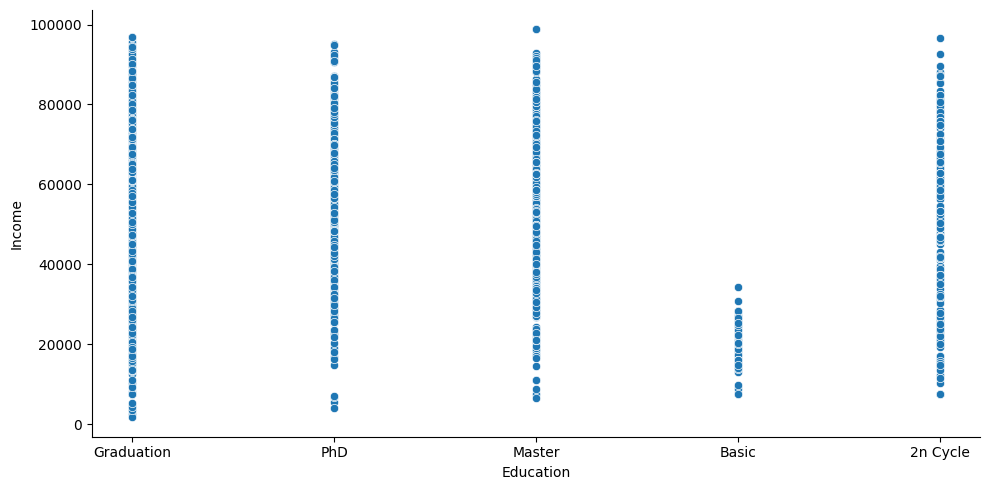

In [12]:
g = sns.relplot(
    data=marketing_df,
    x="Education",
    y="Income",
    kind="scatter",
    aspect=2,
)

Чем меньше образование, тем меньше заработок 

Матрица кореляции

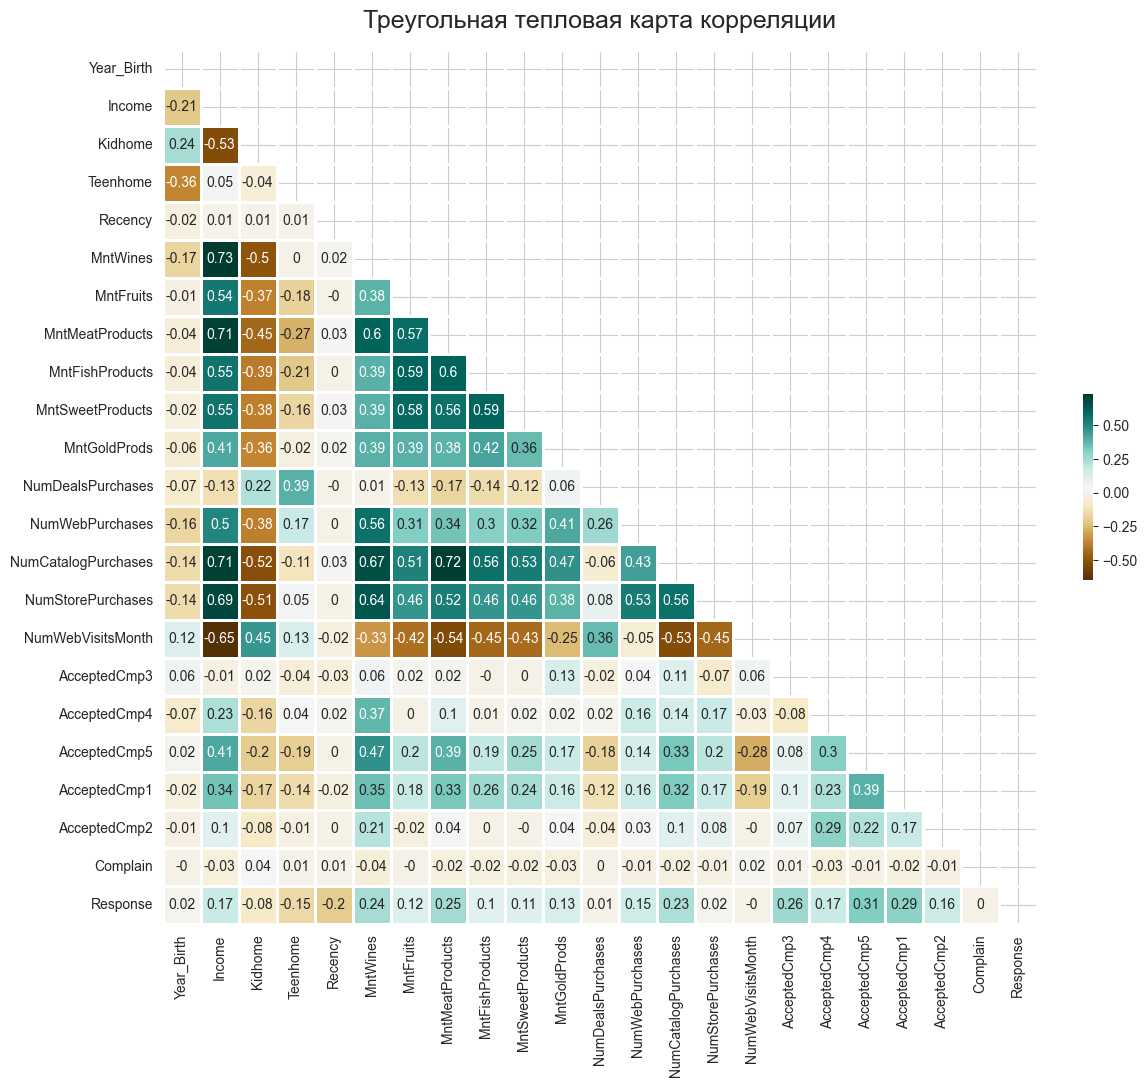

In [13]:
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 12) # [6.4, 4.8]

# Воспользуемся функциями np.triu, чтобы изолировать верхний треугольник (np.tril нижний)
# функция np.ones_like() изменит все изолированные значения на 1.
tmp_df = marketing_df.drop(columns=['ID', 'Z_CostContact', 'Z_Revenue'])
mask = np.triu(np.ones_like(tmp_df.corr(numeric_only=True), dtype=bool))

heatmap = sns.heatmap(
    tmp_df.corr(numeric_only=True).round(2),
    annot=True,
    square=True,
    cmap="BrBG",
    cbar_kws={"fraction": 0.01},
    linewidth=1,
    mask=mask
)

heatmap.set_title(
    "Треугольная тепловая карта корреляции", fontdict={"fontsize": 18}, pad=16
);

- чем больше покупок, тем больше заработок
- принятие предложения зависит от уровня дохода человека
- принятие предложения зависит от расходов на покупку вина

Promotions group

С какого раза человек принял предложение? (0 - значит не принял)

In [14]:
plt.rcParams["figure.figsize"] = [6.4, 4.8]

In [15]:
for i in range(1, 6):
    marketing_df[f'AcceptedCmp{i}'] = marketing_df[f'AcceptedCmp{i}'] * i

In [16]:
marketing_df['accepted_cmp_num'] = marketing_df[['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 
                        'AcceptedCmp1', 'AcceptedCmp2']].values.max(axis=1)

In [17]:
marketing_df['Dt_Customer'] = pd.to_datetime(marketing_df['Dt_Customer'], format="%d-%m-%Y")

Модель

In [18]:
n_splits = 5

target_column = 'accepted_cmp_num'
train_columns = marketing_df.columns.to_list()
train_df = marketing_df[marketing_df.accepted_cmp_num != 2].copy()[train_columns]
cat_features = ['Education', 'Marital_Status']
ignored_features = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 
                        'AcceptedCmp1', 'AcceptedCmp2', 'ID']
train_df = train_df.drop(columns=ignored_features)

X = train_df.drop(columns=[target_column])
y = train_df[target_column]

In [19]:
clfs = []
scores = []
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

for train_index, test_index in kf.split(X, y):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    clf = CatBoostClassifier(
        depth=6,
        iterations=500,
        learning_rate=0.06,
        loss_function="MultiClass", 
        eval_metric="TotalF1:average=Macro", 
        custom_metric="TotalF1:average=Macro",
        boosting_type="Ordered",
        
        cat_features=cat_features,
        colsample_bylevel=0.098,
        subsample=0.95,
        l2_leaf_reg=9,
        min_data_in_leaf=243,
        max_bin=187,
        random_strength=1,
        
        
        task_type="CPU",    
        thread_count=-1,
        bootstrap_type="Bernoulli", 
        

        random_seed=7575,
        early_stopping_rounds=50)

    clfs.append(clf)

    clf.fit(
        X_train, y_train,
        eval_set=(X_test, y_test),
        verbose=100,
        use_best_model=True,
        plot=False)

    y_pred = clf.predict(X_test)
    score = f1_score(y_test, y_pred, average="macro")  
    scores.append(score)
    print(f"\nfold: f1 score: {score} \n")

assert len(clfs) == n_splits
print(
    "mean f1 score ====>>> " + str(np.mean(scores, dtype="float32")) + " <<<====", np.std(scores).round(4), "\n"
)

0:	learn: 0.2655671	test: 0.3070580	best: 0.3070580 (0)	total: 133ms	remaining: 1m 6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3070580475
bestIteration = 0

Shrink model to first 1 iterations.

fold: f1 score: 0.30705804749340365 

0:	learn: 0.2814664	test: 0.2582762	best: 0.2582762 (0)	total: 6.88ms	remaining: 3.43s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2582762275
bestIteration = 0

Shrink model to first 1 iterations.

fold: f1 score: 0.2582762274814553 

0:	learn: 0.2795639	test: 0.2741733	best: 0.2741733 (0)	total: 12ms	remaining: 6.01s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2741732804
bestIteration = 0

Shrink model to first 1 iterations.

fold: f1 score: 0.27417328042328043 

0:	learn: 0.1770596	test: 0.1769328	best: 0.1769328 (0)	total: 14.6ms	remaining: 7.26s
100:	learn: 0.3014164	test: 0.3071808	best: 0.3071808 (91)	total: 2.14s	remaining: 8.46s
200:	learn: 0.3899623	test: 0.3880045	best: 0.38

для оценки важности признаков будем использовать shap values

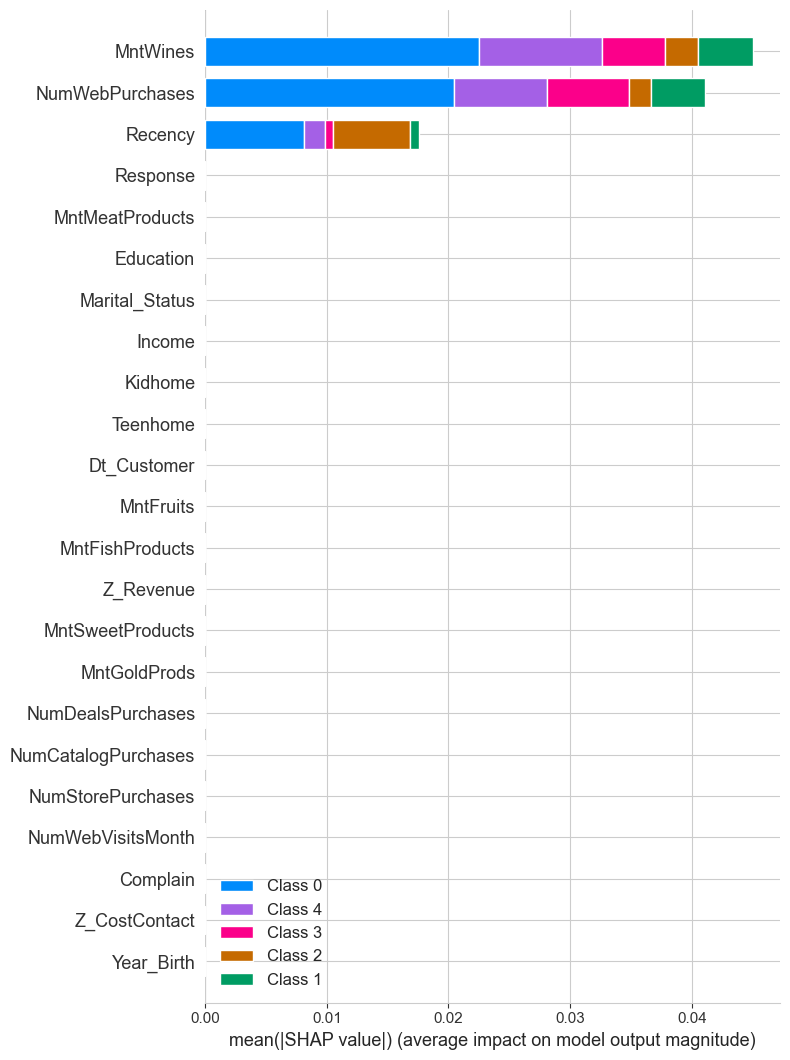

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

explainer = shap.TreeExplainer(clfs[0])

val_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X_test, max_display=100)

Расходы на вино и кол - во покупок через интернет - самые выжные признаки для определения номера компании